Data: http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/

https://sci2s.ugr.es/keel/dataset.php?cod=113

## Introduction
In phonetics, it is generally known that the resonant frequencies of the vocal tract of the speaker can be used to determine the quality of the vowel being spoken. See more on [Wikipedia Formant page](https://en.wikipedia.org/wiki/Formant).

Here I have taken data of English speakers pronouncing eleven different vowels in their language. The data is taken from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Vowel+Recognition+-+Deterding+Data%29).

The data consists of 15 speakers each pronouncing 11 vowels, six times each. The phonetic data is then processed, and classified as formants from f0 to f9, and recorded together with data about which speaker has made the sound and the sex of the speaker.

The data file came from [here](http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.data).

## Imports and Settings

In [113]:
import pandas as pd
# import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sklearn
pd.set_option('display.max_rows', 200)
from statistics import mean

## Data Exploration

In [44]:
df = pd.read_csv('vowels_data.csv')
df

,train_test,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0
1,0,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,0,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,0,0,0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3
4,0,0,0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1,14,1,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,6
986,1,14,1,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,7
987,1,14,1,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,8
988,1,14,1,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,9


Speakers are labeled from 0 to 14. Sex 0 is male and 1 is female, according to [the documentation](http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.names).

The vowels are encoded from 0 to 10. I would like to be able to express them as actual vowels, so the following function does that (referring to [the documentation](http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/vowel-context.names).

In [45]:
def convert_to_vowel(vowel_int):
    convert = {
    0: 'hid',
	1: 'hId',		
	2: 'hEd',
	3: 'hAd',		
	4: 'hYd',		
	5: 'had',		
	6: 'hOd',		
	7: 'hod',		
	8: 'hUd',		
	9: 'hud',		
	10: 'hed'
    }
    return convert.get(vowel_int, "No vowel given")

The original data comes with a pre-determined train-test split, but I wanted to use my own, so I removed this column.

In [46]:
df.drop(columns = "train_test", inplace = True)

### Train and Test Data

It's tricky to know how to split the data for train/val/test. Although I have 990 rows of data, they are only spoken by 15 people, and it is reasonable to think that the person speaking is likely to have a significant impact on the data.

If I were to split the 990 rows randomly, I would have data leakage from the test data into the training data, since some of the training data would come from the same people who also produced test data.

Therefore I decided to split off the test data according to people. I chose two male and two female speakers to constitute the test data.

I considered whether or not I should take a similar approach for the validation data. In the end I decided to use a manual cross-validation, where I held back one person from the training data each time to be used for validation, and then took the mean of the evaluation metrics.

In [47]:
df_test = df[df.speaker.isin([10, 11, 13, 14])]  # Two male and two female in df_test

In [74]:
df_train = df[df.speaker.isin([0,1,2,3,4,5,6,7,8,9,12])]
df_train = df_train.sample(frac=1).reset_index(drop=True)  # Randomise the order of the training examples

In [117]:
df_train.head()

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,0,0,-3.141,1.873,-1.131,0.941,-0.759,1.224,-0.354,0.016,-0.218,-0.568,4
1,12,1,-2.247,3.420,-0.887,-0.823,-0.297,0.774,0.185,-0.242,-0.790,0.046,4
2,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,9,0,-1.951,1.684,-1.039,0.586,-1.166,0.345,0.330,-0.108,-0.198,-0.609,3
4,12,1,-3.376,3.327,-0.797,-0.849,-0.681,1.198,0.838,0.244,-0.298,-0.618,7


Types of columns:

In [50]:
df_train.dtypes

speaker      int64
sex          int64
f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
f5         float64
f6         float64
f7         float64
f8         float64
f9         float64
vowel        int64
dtype: object

## Missing Values

In [51]:
df_train.isnull().sum()

speaker    0
sex        0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
vowel      0
dtype: int64

No missing values. Yay!

## Exploration of features

<AxesSubplot:>

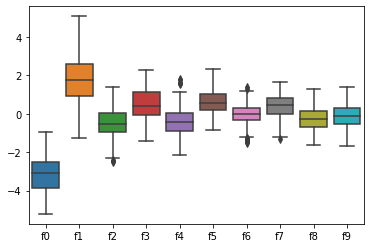

In [52]:
sns.boxplot(data = df_train[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']])

In [53]:
from sklearn.feature_selection import mutual_info_classif

In [119]:
MI = mutual_info_classif(df_train.drop(['vowel', 'speaker'], axis=1), df_train['vowel'])

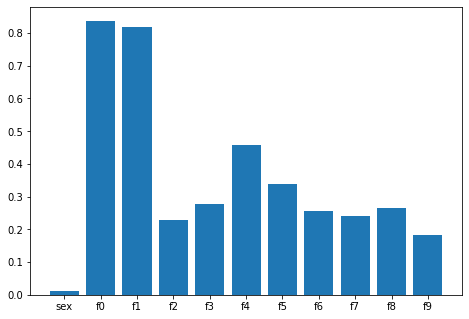

In [120]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train.drop(['vowel', 'speaker'], axis=1).columns, MI)
plt.show()

It seems that f0 and f1 have the largest impact on the vowel.

## Build and test some initial models

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

Set up a function that will take a model and run a cross-validation test on it, using the data of one speaker at a time for validation. The function returns the AUC and accuracy.

In [58]:
def evaluate_model(model, df_train = df_train):
    speakers = df_train['speaker'].unique()
    scores = []
    accuracy = []
    for speaker in speakers:
        df_train = df_train.copy()
        X_train = df_train[df_train['speaker'] != speaker]
        X_val = df_train[df_train['speaker'] == speaker]
        y_train = df_train.loc[df_train['speaker'] != speaker]['vowel']
        y_val = df_train.loc[df_train['speaker'] == speaker]['vowel']
        model.fit(X_train.drop(['vowel', 'speaker'], axis=1), y_train)
        y_preds_proba = model.predict_proba(X_val.drop(['vowel', 'speaker'], axis=1))
        y_preds = model.predict(X_val.drop(['vowel', 'speaker'], axis=1))
        scores.append(roc_auc_score(y_val, y_preds_proba, multi_class='ovo'))
        accuracy.append(mean((y_preds == y_val).astype(int)))
    return mean(scores), mean(accuracy)

#### Logistic Regression

In [67]:
lr = LogisticRegression(multi_class="multinomial", solver='saga')
AUC, accuracy = evaluate_model(lr)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: Conver

AUC: 0.9114784205693297
Accuracy: 0.4834710743801653


/home/mark/.local/share/virtualenvs/MLZoomCamp-_LaD5eOB/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest

In [12]:
rf = RandomForestClassifier()
AUC, accuracy = evaluate_model(rf)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.9389807162534435
Accuracy: 0.5950413223140496


#### Gradient Boosting

In [13]:
gb = GradientBoostingClassifier()
AUC, accuracy = evaluate_model(gb)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.8944674012855831
Accuracy: 0.5206611570247934


## Tuning Hyperparameters

It seems from that Random Forest is the most promising, so I will aim to tune its hyperparameters.

### Random Forest

In [17]:
n_estimators_list = [25, 50, 100, 200, 400, 800, 1600]

In [77]:
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n)
    print(f'n_estimators: {n} \t AUC: {evaluate_model(rf)}')

NameError: name 'n_estimators_list' is not defined

In [78]:
n_estimators_list = [300, 400, 500, 600, 800, 1200, 1600]

In [79]:
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n)
    print(f'n_estimators: {n} \t AUC: {evaluate_model(rf)}')

n_estimators: 300 	 AUC: (0.9488062442607896, 0.5936639118457301)
n_estimators: 400 	 AUC: (0.9483930211202939, 0.59366391184573)
n_estimators: 500 	 AUC: (0.9502295684113866, 0.6060606060606061)
n_estimators: 600 	 AUC: (0.9468089990817263, 0.5881542699724518)
n_estimators: 800 	 AUC: (0.9506198347107438, 0.6019283746556474)
n_estimators: 1200 	 AUC: (0.9518595041322314, 0.6005509641873278)
n_estimators: 1600 	 AUC: (0.9525022956841139, 0.5936639118457301)


In [80]:
max_depth_list = [10, 15, 20, 30, 50]

In [81]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=500, max_depth=m)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

max_depth: 10 	 AUC: (0.9490472910927457, 0.6060606060606061)
max_depth: 15 	 AUC: (0.9505853994490358, 0.6088154269972452)
max_depth: 20 	 AUC: (0.9520431588613407, 0.5867768595041323)
max_depth: 30 	 AUC: (0.9485192837465565, 0.5922865013774105)
max_depth: 50 	 AUC: (0.9485766758494032, 0.6046831955922864)


In [82]:
max_depth_list_short = [10, 15, 20]
n_estimators_list_short = [400, 500, 600, 800]

In [85]:
for m in max_depth_list_short:
    for n in n_estimators_list_short:
        rf = RandomForestClassifier(n_estimators=n, max_depth=m)
        print(f'max_depth: {m}, n_estimators: {n} \t AUC, Accuracy: {evaluate_model(rf)}')

max_depth: 10, n_estimators: 400 	 AUC, Accuracy: (0.9482782369146006, 0.5895316804407713)
max_depth: 10, n_estimators: 500 	 AUC, Accuracy: (0.9493342516069789, 0.5826446280991735)
max_depth: 10, n_estimators: 600 	 AUC, Accuracy: (0.9477157943067034, 0.5881542699724518)
max_depth: 10, n_estimators: 800 	 AUC, Accuracy: (0.9507116620752984, 0.5840220385674931)
max_depth: 15, n_estimators: 400 	 AUC, Accuracy: (0.9484504132231405, 0.5922865013774105)
max_depth: 15, n_estimators: 500 	 AUC, Accuracy: (0.948714416896235, 0.5964187327823691)
max_depth: 15, n_estimators: 600 	 AUC, Accuracy: (0.947704315886134, 0.5977961432506887)
max_depth: 15, n_estimators: 800 	 AUC, Accuracy: (0.9522842056932965, 0.5964187327823691)
max_depth: 20, n_estimators: 400 	 AUC, Accuracy: (0.9484044995408631, 0.5840220385674931)
max_depth: 20, n_estimators: 500 	 AUC, Accuracy: (0.9495752984389348, 0.5964187327823691)
max_depth: 20, n_estimators: 600 	 AUC, Accuracy: (0.9503673094582186, 0.6033057851239669)
m

### Best model

In [88]:
rf = RandomForestClassifier(n_estimators=800, max_depth=15)
AUC, accuracy = evaluate_model(rf)
print(f'AUC: {AUC}\nAccuracy: {accuracy}')

AUC: 0.9499081726354454
Accuracy: 0.5909090909090909


## Exporting the Model

I will export the best model I have found:

In [89]:
model = RandomForestClassifier(n_estimators=800, max_depth=15)
model.fit(df_train.drop(['vowel', 'speaker'], axis=1), df_train['vowel'])

RandomForestClassifier(max_depth=15, n_estimators=800)

In [90]:
import pickle 

with open('vowel-model.bin', 'wb') as f_out:
    pickle.dump((model), f_out)

## Test Example

A random example from the test data:

In [109]:
# Pick a random example from the test set

random_index = random.randint(0, df_test.shape[0] - 1)
random_index

example = df_test.drop(['speaker', 'vowel'], axis=1).iloc[[random_index,]]
example = example.to_dict()
vowel_int = df_test.iloc[random_index]['vowel'].astype(int)
print(f'Actual vowel: {convert_to_vowel(vowel_int)}')

Actual vowel: hed


This example, predicted from the locally run model:

In [110]:
vowel_int = model.predict(df_test.drop(['speaker', 'vowel'], axis=1).iloc[[random_index,]])[0]
print(f'Predicted vowel: {convert_to_vowel(vowel_int)}')

Predicted vowel: hed


This example, predicted from the locally run Docker file:

In [111]:
# import requests
# url = 'http://localhost:9696/predict'
# response = requests.post(url, json=example)
# result = response.json()
# result

TRemotely run Docker file on Heroku:

In [112]:
import requests
url = 'https://zoomcamp-midterm-heroku.herokuapp.com/predict'
response = requests.post(url, json=example)
result = response.json()
result

{'Prediction': 'hed'}

## Docker Deployment

To build, make sure you're in the directory containing the Dockerfile, Pipfile, Pipfile.lock, vowel-model.bin and predict_vowel.py. Then: 

```sudo docker build -t zoomcamp-midterm .```

To run:

```sudo docker run -it --rm -p 9696:9696 zoomcamp-midterm:latest```

## Deploying Docker to Heroku
I followed [this guide](https://github.com/nindate/ml-zoomcamp-exercises/blob/main/how-to-use-heroku.md) for deploying Docker to Heroku. I needed to not specify the port, which meant modifying predict.py:
```if __name__ == '__main__':
    port = int(os.environ.get("PORT", 5000))  # For deployment to Heroku
    app.run(host='0.0.0.0', port=port)  # When deployed locally, used port 9696```
    
I also needed to add a Procfile with the following:

```web: gunicorn predict_vowel:app 0.0.0.0:$PORT```

These adaptations came from [this guide](https://dev.to/ejach/how-to-deploy-a-python-flask-app-on-heroku-using-docker-mpc).

### Updating via Git
I can now update via Git by making the changes in the directory, and then running 

```git push heroku main```

This will automatically build the new Docker image and deploy it to Heroku.